In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


import dask
import dask.dataframe as dd
import dask.array as da
from dask.diagnostics import ProgressBar

from shapely.geometry import Polygon, box, Point

from faker import Faker
import random
from scipy.stats import zscore



In [3]:

variables = ['Level', 'ClientMacAddr', 'lat', 'lng', 'localtime']

# Read the CSV file with Dask
data = dd.read_csv('Data/dataset_1.csv', usecols=variables)

# data.to_parquet('kiana.parquet', engine='pyarrow')
data['lng'] = data['lng'].map_partitions(lambda x: pd.to_numeric(x, errors='coerce'), meta=('lng', 'float64'))
data['lat'] = data['lat'].map_partitions(lambda x: pd.to_numeric(x, errors='coerce'), meta=('lat', 'float64'))

data['localtime'] = dd.to_datetime(data['localtime'], errors='coerce')

In [3]:

def process_mobility_data(data_path='kiana.parquet'):
    # Read the data using Dask
    data = dd.read_parquet(data_path).partitions[:2]  # Adjust based on input 
    
    # Create metadata for the DataFrame
    initial_meta = {
        'Level': 'object',
        'ClientMacAddr': 'object',
        'lat': 'float64',
        'lng': 'float64',
        'localtime': 'datetime64[ns]'
    }

    meta = initial_meta.copy()
    meta.update({
        'time_diff': 'float64',
        'prev_latitude': 'float64',
        'prev_longitude': 'float64',
        'distance': 'float64',
        'speed': 'float64'
    })

    # Sort the data
    data = data.map_partitions(
        lambda df: df.sort_values(['ClientMacAddr', 'localtime']),
        meta=initial_meta
    )
   
    
    # Calculate time difference and previous coordinates
    def process_group(df, partition_info=None):
        if partition_info is not None:
            print(f"Processing partition {partition_info['number']}")
            print(f"Partition {partition_info['number']} size: {len(df)} rows")

        # Sort within each partition
        df = df.sort_values(['ClientMacAddr', 'localtime'])

        # print('calculating time difference in process_group')
        
        # Calculate time difference
        df['localtime'] = pd.to_datetime(df['localtime'], errors='coerce')
        

        
        df['time_diff'] = df.groupby('ClientMacAddr')['localtime'].diff().dt.total_seconds() / 60
        
        # print('calculating previous coordinates in process_group')
        
        # Calculate previous coordinates
        df['prev_latitude'] = df.groupby('ClientMacAddr')['lat'].shift()
        df['prev_longitude'] = df.groupby('ClientMacAddr')['lng'].shift()

        # print('calculating Haversine distance in process_group')

        R = 6371000  # Earth's radius in meters
        
        lat1 = np.radians(df['prev_latitude'])
        lon1 = np.radians(df['prev_longitude'])
        lat2 = np.radians(df['lat'])
        lon2 = np.radians(df['lng'])
        
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        df['distance'] = R * c
        # print('calculating speed in process_group')

        # Calculate speed
        df['speed'] = df['distance'] / df['time_diff']
        
        # Drop NaN values
        df = df.dropna()
        
        return df

    print('calling function: process_group')
    
    # Apply all calculations
    data = data.map_partitions(process_group, meta=meta)

    
    data = data.persist()

    print('filtering using time difference')

    # Filter data based on time difference
    data = data[(data['time_diff'] > 0.1) & (data['time_diff'] < 30)]
    
    print('calculating average speed')

    # Calculate average speeds
    average_speeds = data.groupby('ClientMacAddr')['speed'].mean().reset_index()
    average_speeds.columns = ['ClientMacAddr', 'avg_speed']
    
    # Compute to materialize the results
    average_speeds = average_speeds.compute()

   

   
    return average_speeds

In [4]:
average_speeds = process_mobility_data()
average_speeds

calling function: process_group
Processing partition 0Processing partition 1
Partition 1 size: 644956 rows

Partition 0 size: 648545 rows
filtering using time difference
calculating average speed


,ClientMacAddr,avg_speed
0,00:0c:e7:08:6e:1c,0.000000
1,00:0c:e7:32:83:c6,0.000000
2,00:0c:e7:59:26:3f,0.000000
3,00:0c:e7:6d:cc:85,0.000000
4,00:0c:e7:bf:ea:02,0.534015
...,...,...
985,f4:f5:24:d9:c4:ad,0.000000
986,f4:f5:24:db:c6:78,0.000000
987,f4:f5:24:e5:3c:93,0.859157
988,f4:f5:24:ef:33:15,0.000000


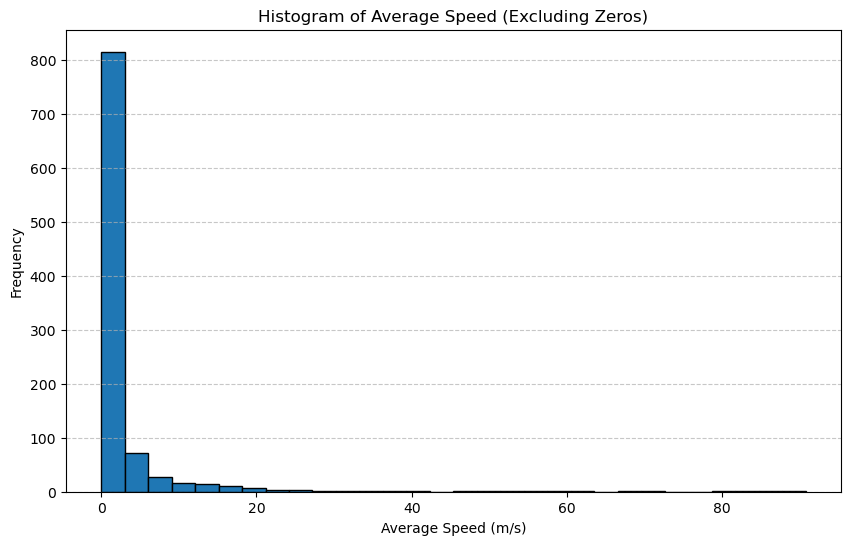

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(average_speeds['avg_speed'], bins=30, edgecolor='black')
plt.xlabel('Average Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Histogram of Average Speed (Excluding Zeros)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [6]:
average_speeds['mobile'] = np.where(average_speeds['avg_speed'] > 1.2, 1, 0)
average_speeds = average_speeds[['ClientMacAddr', 'avg_speed', 'mobile']]
average_speeds

,ClientMacAddr,avg_speed,mobile
0,00:0c:e7:08:6e:1c,0.000000,0
1,00:0c:e7:32:83:c6,0.000000,0
2,00:0c:e7:59:26:3f,0.000000,0
3,00:0c:e7:6d:cc:85,0.000000,0
4,00:0c:e7:bf:ea:02,0.534015,0
...,...,...,...
985,f4:f5:24:d9:c4:ad,0.000000,0
986,f4:f5:24:db:c6:78,0.000000,0
987,f4:f5:24:e5:3c:93,0.859157,0
988,f4:f5:24:ef:33:15,0.000000,0


In [59]:
# average_speeds.to_csv('average_speeds_11-11.csv')

In [3]:
average_speeds = pd.read_csv('Intermediate Data/average_speeds.csv')
data = dd.read_parquet('Data/kiana.parquet')

In [5]:
# 1 min
from dask import delayed

# Assuming `data` is a Dask DataFrame with columns: Site, Level, ClientMacAddr, lat, lng, localtime
# Assuming `average_speeds` is another Dask DataFrame with columns: ClientMacAddr, avg_speed, mobile

# Step 1: Join the `data` and `average_speeds` DataFrames on `ClientMacAddr`
merged_data = data.merge(average_speeds, on='ClientMacAddr', how='inner')

# Step 2: Filter the data to only include rows where mobile = 0
mobile_data = merged_data[merged_data['mobile'] == 0]

# Step 3: Sort data by ClientMacAddr and localtime to ensure chronological order
# Sorting in Dask works within each partition, so apply it carefully
mobile_data = mobile_data.map_partitions(
    lambda df: df.sort_values(by=['ClientMacAddr', 'localtime'])
)

# Step 4: Create a column for the previous level by shifting the Level column within each ClientMacAddr group
# Dask does not directly support `groupby().shift()`, so we use map_partitions with custom logic
def add_previous_level(df):
    df['prev_level'] = df.groupby('ClientMacAddr')['Level'].shift(1)
    return df

mobile_data = mobile_data.map_partitions(add_previous_level)

# Step 5: Identify where a level change occurs
mobile_data['level_changed'] = mobile_data['Level'] != mobile_data['prev_level']

# Step 6: Calculate the time difference between entries for each ClientMacAddr
def calculate_time_diff(df):
    df['time_diff'] = df.groupby('ClientMacAddr')['localtime'].diff()
    return df

mobile_data = mobile_data.map_partitions(calculate_time_diff)

# Step 7: Filter for rows where a level change occurred
level_changes = mobile_data[mobile_data['level_changed']]

# Step 8: Group by ClientMacAddr, previous level, and current level to calculate transition counts and total time spent
# Dask does not support multi-level groupby with aggregations directly, so use aggregate with `delayed`
@delayed
def compute_time_spent(df):
    grouped = df.groupby(['ClientMacAddr', 'prev_level', 'Level']).agg(
        transition_count=('level_changed', 'size'),   # Count occurrences of each transition
        total_time=('time_diff', 'sum')               # Sum time spent at each previous level before transitioning
    ).reset_index()  # Ensure group-by columns are retained as columns, not index
    return grouped

# Compute time spent across all partitions
time_spent = compute_time_spent(level_changes.compute())

# Step 9: Convert back to Dask DataFrame for further processing
time_spent = dd.from_delayed([time_spent])

# Step 10: Rank by transition_count and total_time in descending order
# Add ranking columns within each partition (ensure large partition size for accurate ranking)
time_spent = time_spent.map_partitions(
    lambda df: df.assign(
        transition_rank=df['transition_count'].rank(method='dense', ascending=False),
        time_rank=df['total_time'].rank(method='dense', ascending=False)
    )
)

# Step 11: Sort by both transition_count and total_time to see the ranking order
time_spent = time_spent.sort_values(by=['transition_count', 'total_time'], ascending=[False, False]).reset_index(drop=True)

# Persist and display results
time_spent = time_spent.persist()
time_spent.compute()

,ClientMacAddr,prev_level,Level,transition_count,total_time,transition_rank,time_rank
0,48:a4:72:ae:11:81,0.0,2,5,860 days 15:40:00.431000,1.0,4.0
1,88:66:a5:0e:6f:3f,2.0,0,5,769 days 18:37:42.612000,1.0,9.0
2,00:80:92:df:7b:97,2.0,0,4,864 days 14:51:02.512000,2.0,3.0
3,cc:44:63:3c:40:8b,2.0,0,4,676 days 14:04:56.383000,2.0,13.0
4,8c:f5:a3:cd:d2:db,2.0,0,4,363 days 06:15:04.974000,2.0,86.0
...,...,...,...,...,...,...,...
459,28:16:ad:17:e4:b3,2.0,0,1,66 days 23:44:38.279000,5.0,459.0
460,88:66:a5:e2:de:d1,2.0,0,1,66 days 23:41:01.442000,5.0,460.0
461,00:b3:62:26:15:04,2.0,0,1,66 days 23:38:29.989000,5.0,461.0
462,9c:da:3e:7f:8e:01,2.0,0,1,66 days 23:38:28.429000,5.0,462.0


In [7]:

# Ensure both DataFrames are Dask DataFrames
# Uncomment these lines if either DataFrame is not yet a Dask DataFrame
# average_speeds = dd.from_pandas(average_speeds, npartitions=4)
# time_spent = dd.from_pandas(time_spent, npartitions=4)

transition_threshold = 5

average_speeds = dd.from_pandas(average_speeds, npartitions=4)

# Step 1: Filter `time_spent` for `ClientMacAddr` values exceeding the transition threshold
exceeding_threshold = time_spent[time_spent['transition_count'] > transition_threshold][['ClientMacAddr']]

exceeding_threshold['above_threshold'] = 1

# Step 3: Merge `average_speeds` with `exceeding_threshold` on `ClientMacAddr`
average_speeds = average_speeds.merge(exceeding_threshold,on='ClientMacAddr', how='left')


# Step 4: Update `mobile` column based on whether `transition_count` exceeded threshold
average_speeds['mobile'] = average_speeds['above_threshold'].fillna(average_speeds['mobile']).astype(int)

# Drop the `above_threshold` column used for merging
average_speeds = average_speeds.drop(columns=['above_threshold'])


# Compute the final result if needed
average_speeds = average_speeds.compute()

average_speeds

,ClientMacAddr,avg_speed,mobile
0,10:02:b5:e3:08:cd,6.144330,0
1,28:16:ad:17:e3:e6,7.010874,0
2,a4:c3:f0:a5:f0:c8,6.577559,0
3,0c:51:01:b6:45:72,3.710380,0
4,48:45:20:4c:11:89,11.481983,0
...,...,...,...
30878,d0:77:14:fb:bd:59,2.237154,0
30879,d0:77:14:e7:69:55,0.000000,0
30880,cc:44:63:16:3d:be,0.000000,0
30881,08:e6:89:8a:53:c8,0.000000,0


In [15]:
# average_speeds = pd.read_csv('average_speeds_11-11.csv')

In [11]:
average_speeds['mobile'].sum()

3096

In [22]:
average_speeds['mobile'].value_counts()

mobile
0    120439
1      3096
Name: count, dtype: int64

In [13]:
# Assuming 'data' and 'average_speeds' are already Dask DataFrames

# Filter `average_speeds` for mobile devices and create `cluster_1_data`
cluster_1_data = average_speeds[average_speeds['mobile'] == 1]

# Step 1: Convert `cluster_1_data['ClientMacAddr']` to a Pandas Series for compatibility with `isin`
#client_mac_addresses = cluster_1_data['ClientMacAddr'].compute()  # This brings the Series into memory as Pandas

# Step 2: Filter 'data' based on 'ClientMacAddr' values in `client_mac_addresses`
filtered_data = data[data['ClientMacAddr'].isin(cluster_1_data['ClientMacAddr'])]

# Step 3: Count frequency of each 'ClientMacAddr' in 'filtered_data'
mac_id_counts = filtered_data.groupby('ClientMacAddr').size().reset_index()

mac_id_counts.columns = ['ClientMacAddr', 'frequency']
# Step 4: Sort by frequency in ascending order
mac_id_counts = mac_id_counts.sort_values(by='frequency', ascending=True).reset_index(drop=True)

# Step 5: Classify as 'visitor' if frequency is less than 10, otherwise as 'employee'
mac_id_counts['classification'] = mac_id_counts['frequency'].map(lambda x: 'visitor' if x < 10 else 'employee')

# Compute to view the result
mac_id_counts = mac_id_counts.compute()
mac_id_counts

C:\Users\ctric\AppData\Roaming\Python\Python312\site-packages\dask_expr\_collection.py:4196: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('frequency', 'object'))

  warnings.warn(meta_warning(meta))


,ClientMacAddr,frequency,classification
0,f0:d7:aa:5c:ea:af,2,visitor
1,b8:6b:23:f3:d8:a7,2,visitor
2,d8:55:75:7c:e7:ef,2,visitor
3,98:5f:d3:3b:d3:7c,2,visitor
4,a8:c8:3a:03:d3:55,2,visitor
...,...,...,...
500,4c:34:88:bd:ff:25,13409,employee
501,0c:51:01:b3:40:2e,13453,employee
502,34:42:62:bf:12:a4,15742,employee
503,48:5a:3f:96:11:bf,17135,employee


In [15]:
mac_id_counts['classification'].value_counts()

classification
employee    2824
visitor      272
Name: count, dtype: int64

In [107]:
# Convert cluster_1_data to Dask DataFrame (if it isn't already)
mac_id_counts = dd.from_pandas(mac_id_counts, npartitions=4)

In [29]:
# Initialize Faker and random seed
fake = Faker('en_US')
Faker.seed(0)
random.seed(0)

job_titles = [
    "Software Engineer", "Data Scientist", "Project Manager", "Product Manager", "Marketing Specialist",
    "Sales Executive", "Business Analyst", "Financial Analyst", "Graphic Designer", "UX/UI Designer",
    "Network Administrator", "Database Administrator", "Technical Writer", "Systems Analyst", 
    "Human Resources Manager", "Operations Manager", "Legal Consultant", "Customer Service Manager",
    "Quality Assurance Specialist", "Machine Learning Engineer", "Cybersecurity Analyst", "DevOps Engineer",
    "Cloud Architect", "IT Support Specialist", "Digital Marketing Manager", "Content Strategist",
    "SEO Specialist", "E-commerce Manager", "Logistics Coordinator", "Supply Chain Analyst",
    "Product Designer", "Chief Technology Officer", "Chief Marketing Officer", "Social Media Manager",
    "Account Executive", "Corporate Trainer", "Recruitment Specialist", "Copywriter", 
    "Public Relations Manager", "Research Scientist", "Biomedical Engineer", "Mechanical Engineer",
    "Civil Engineer", "Environmental Consultant", "Healthcare Administrator", "Laboratory Technician",
    "Clinical Research Associate", "Data Engineer", "Chief Financial Officer", "Legal Assistant",
    "Janitor", "Security Guard", "Warehouse Worker", "Forklift Operator", "Maintenance Technician",
    "Receptionist", "Administrative Assistant", "Customer Service Representative", "Cashier", 
    "Barista", "Sales Associate", "Warehouse Manager", "Production Worker", "Truck Driver",
    "Office Clerk", "Facilities Manager", "Food Service Worker", "Retail Associate", "Inventory Clerk"
]

# Apply random values in parallel with Dask
def assign_synthetic_data(df):
    df['Name'] = [fake.name() for _ in range(len(df))]
    

    df['Job_Title'] = dd.from_array(np.where(
        df['classification'] == 'employee',
        [random.choice(job_titles) for _ in range(len(df))],
        None
    ))

    df['security_level'] = dd.from_array(np.where(
        df['classification'] == 'employee',
        [random.randint(0, 3) for _ in range(len(df))],
        None
    ))
    return df

# Create metadata for the output DataFrame
meta = pd.DataFrame({
    'ClientMacAddr': pd.Series(dtype='str'),
    'frequency': pd.Series(dtype='int64'),
    'classification': pd.Series(dtype='str'),
    'Name': pd.Series(dtype='str'),
    'Job_Title': pd.Series(dtype='object'),
    'security_level': pd.Series(dtype='float64')
})


# Compute the Dask DataFrame to see the results
mac_id_counts = mac_id_counts.map_partitions(assign_synthetic_data, meta=meta)

# Select relevant columns to create df_employee
employee_and_visitor = mac_id_counts[['ClientMacAddr', 'frequency', 'Name', 'Job_Title', 'security_level','classification']]

# Compute results for Dask
employee_and_visitor = employee_and_visitor.compute()
employee_and_visitor

,ClientMacAddr,frequency,Name,Job_Title,security_level,classification
0,f0:d7:aa:5c:ea:af,2,Bridget Thompson,<NA>,<NA>,visitor
0,80:58:f8:40:03:a2,13,Margaret Sanchez,Supply Chain Analyst,0,employee
0,60:1d:91:2f:ed:c0,11,Lori Dougherty,Office Clerk,2,employee
0,80:58:f8:86:ee:d7,60,Dr. Michael Williams,Marketing Specialist,3,employee
0,24:46:c8:fd:9c:d5,14,Douglas Jackson,Legal Assistant,3,employee
...,...,...,...,...,...,...
570,80:58:f8:8c:82:6b,30,Corey Mccarty,Warehouse Manager,2,employee
571,80:58:f8:9c:13:c5,30,Benjamin Myers,Security Guard,0,employee
572,80:58:f8:7a:9a:de,30,Kathy Miller,Biomedical Engineer,1,employee
573,80:58:f8:59:18:01,30,Megan Perkins,Barista,0,employee


In [119]:
cluster_0_data = average_speeds[average_speeds['mobile'] == 0]
# Convert `cluster_0_data` to a Dask DataFrame if it's not already
cluster_0_data = dd.from_pandas(cluster_0_data, npartitions=4)

devices = ['Smartphone', 'Laptop', 'Tablet', 'Smartwatch', 'Router', 'Desktop PC', 'high_value_device']
# Random assignment function to apply across partitions
def assign_device_data(df):
    # Seed random for reproducibility
    random.seed(42)
    
    # Assign random devices and importance levels
    df['device'] = np.random.choice(devices, size=len(df))
    df['importance_level'] = np.random.randint(0, 6, size=len(df))  # 0 to 5
    return df

# Apply random assignment to each partition in Dask
cluster_0_data = cluster_0_data.map_partitions(assign_device_data)

# Select relevant columns for the device DataFrame
df_device = cluster_0_data[['ClientMacAddr', 'device', 'importance_level']]

# Persist the data and compute if needed
df_device = df_device.persist()
df_device = df_device.compute()  # Optional, for final output as Pandas DataFrame

# Display the first few rows
df_device


,ClientMacAddr,device,importance_level
0,10:02:b5:e3:08:cd,Router,1
0,88:b4:a6:0e:19:ed,high_value_device,2
0,80:58:f8:e4:e0:dc,Tablet,2
0,88:b4:a6:39:7f:c1,Smartwatch,5
1,28:16:ad:17:e3:e6,Smartwatch,0
...,...,...,...
30882,7c:b2:7d:87:58:16,Tablet,0
30882,48:45:20:2b:c7:c1,Router,2
30883,88:b4:a6:31:e5:29,high_value_device,3
30883,88:b4:a6:09:4b:ea,Smartphone,3


Total number of chunks: 46
Top security chunk selected at index 14 with zone number 15


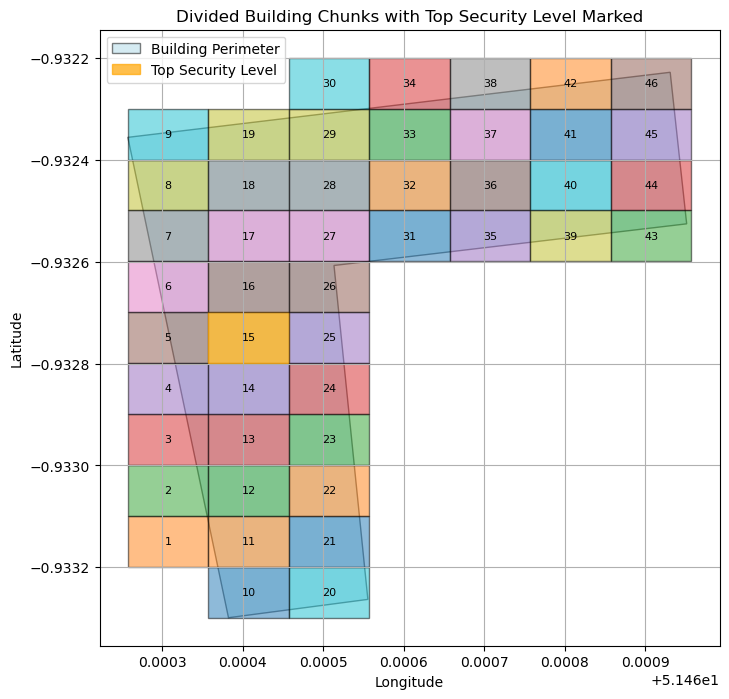

(51.46035717697546,
 -0.9327990938367862,
 51.46045717697546,
 -0.9326990938367862)

In [19]:

# Define corner coordinates (longitude, latitude)
corner_1 = [51.46095123823644, -0.932525400630025]
corner_2 = [51.46093076671099, -0.9322276754361255]
corner_3 = [51.46025717697545, -0.9323554932449286]
corner_4 = [51.46038217497724, -0.9332990938367861]
corner_5 = [51.46055530494714, -0.9332630941041455]
corner_6  = [51.4605132491444, -0.9326072239750992]

# Step 1: Create a Polygon using the corners
corners = [corner_1, corner_2, corner_3, corner_4, corner_5, corner_6]
polygon = Polygon(corners)

# Step 2: Plot the original L-shaped building
x, y = polygon.exterior.xy
plt.figure(figsize=(8, 8))
plt.fill(x, y, alpha=0.5, fc='lightblue', ec='black', label='Building Perimeter')

# Step 3: Create a grid to divide the polygon into chunks
min_lon, min_lat, max_lon, max_lat = polygon.bounds

# Define grid size
grid_size = 0.0001  # Adjust this value to make more or fewer chunks

# Generate grid cells (rectangles) over the bounding box of the polygon
lon_steps = np.arange(min_lon, max_lon, grid_size)
lat_steps = np.arange(min_lat, max_lat, grid_size)

grid_cells = []
zone_labels = []  # To keep track of zone numbers
zone_number = 1  # Start zone numbering from 1

for lon in lon_steps:
    for lat in lat_steps:
        cell = box(lon, lat, lon + grid_size, lat + grid_size)  # Create a rectangular cell
        if polygon.intersects(cell):  # Only keep cells that intersect the building polygon
            grid_cells.append(cell)
            zone_labels.append(zone_number)
            zone_number += 1

# Step 4: Debugging: Check how many chunks are created
print(f"Total number of chunks: {len(grid_cells)}")

# Step 5: Set a random seed for reproducibility
random.seed(8)  # Set the seed

# Randomly select one chunk for top security level
random_index = random.randint(0, len(grid_cells) - 1)
top_security_chunk = grid_cells[random_index]
print(f"Top security chunk selected at index {random_index} with zone number {zone_labels[random_index]}")

# Step 6: Plot the divided chunks, highlighting the top security chunk
for i, (cell, label) in enumerate(zip(grid_cells, zone_labels)):
    x, y = cell.exterior.xy
    if i == random_index:
        plt.fill(x, y, alpha=0.7, ec='red', color='orange', label='Top Security Level')
    else:
        plt.fill(x, y, alpha=0.5, ec='black')
    # Label each zone on the plot
    plt.text(cell.centroid.x, cell.centroid.y, str(label), ha='center', va='center', fontsize=8)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Divided Building Chunks with Top Security Level Marked')
plt.legend()
plt.grid(True)
plt.show()

# Return the boundary coordinates of the top security chunk
top_security_chunk.bounds


In [123]:
# > 3 min

# Assume `data` and `df_device` are Dask DataFrames, and `grid_cells` and `zone_labels` are pre-defined

# Step 1: Filter `data` based on `ClientMacAddr` values in `df_device`
fix_data = data[data['ClientMacAddr'].isin(df_device['ClientMacAddr'])]

# Step 2: Compute the average coordinates for each `ClientMacAddr` in `fix_data`
avg_coordinates = fix_data.groupby('ClientMacAddr').agg({'lat': 'mean', 'lng': 'mean'}).reset_index()
df_device = dd.from_pandas(df_device, npartitions=4)


# Step 3: Merge the average coordinates into `df_device`
df_device = df_device.merge(avg_coordinates, on='ClientMacAddr', how='left')

# Step 4: Define a function that assigns zone based on coordinates for each partition
def assign_zones_partition(df, cells, labels):
    def find_zone(lat, lng):
        point = Point(lat, lng)  # Create a point from lat/lng coordinates
        for cell, label in zip(cells, labels):
            if cell.contains(point):  # Check if the point is inside any cell
                return label
        return None  # If the point doesn't fall within any cell

    # Apply `find_zone` to each row in the DataFrame
    df['zone_number'] = df.apply(lambda row: find_zone(row['lat'], row['lng']), axis=1)
    return df

# Step 5: Use `map_partitions` to apply `assign_zones_partition` across Dask partitions
df_device = df_device.map_partitions(assign_zones_partition, cells=grid_cells, labels=zone_labels)

# Compute the final result to view
# df_device = df_device.compute()
df_device.head()


,ClientMacAddr,device,importance_level,lat,lng,zone_number
0,24:46:c8:2a:80:b3,Desktop PC,3,NaN,NaN,NaN
1,80:58:f8:6f:23:8b,Smartphone,5,NaN,NaN,NaN
2,f4:f5:24:6c:b0:62,Laptop,0,NaN,NaN,NaN
3,80:58:f8:d4:2b:5e,Laptop,5,NaN,NaN,NaN
4,80:58:f8:cb:b4:42,Desktop PC,0,NaN,NaN,NaN


In [ ]:
employee_and_visitor = dd.from_pandas(employee_and_visitor, npartitions=4)

In [41]:
mac_data = employee_and_visitor.merge(data, on='ClientMacAddr', how='left')

# convert security_level to float to avoid error
mac_data.security_level = mac_data.security_level.astype(float)
mac_data.head()

,ClientMacAddr,frequency,Name,Job_Title,security_level,classification,Level,lat,lng,localtime
0,80:58:f8:63:5d:b4,35,Jill Sherman,Software Engineer,1.0,employee,0,51.460786,-0.932225,2019-10-18 15:25:08.367
1,80:58:f8:63:5d:b4,35,Jill Sherman,Software Engineer,1.0,employee,0,51.460786,-0.932225,2019-10-18 15:24:05.995
2,80:58:f8:63:5d:b4,35,Jill Sherman,Software Engineer,1.0,employee,0,51.460598,-0.932394,2019-10-18 15:22:46.482
3,80:58:f8:63:5d:b4,35,Jill Sherman,Software Engineer,1.0,employee,0,51.460598,-0.932394,2019-10-18 15:21:48.415
4,80:58:f8:63:5d:b4,35,Jill Sherman,Software Engineer,1.0,employee,0,51.460786,-0.932225,2019-10-18 15:21:27.356


In [56]:
with ProgressBar():
    mac_data.to_csv('Intermediate Data/employee_device/*.csv')

[########################################] | 100% Completed | 397.26 s


In [21]:
mac_data = dd.read_csv('Intermediate Data/employee_device/*.csv')

In [125]:
# with ProgressBar():
#     total_rows = mac_data.shape[0].compute()
    
# print(f"Total rows in data: {total_rows}")

In [23]:
# with ProgressBar():
#     total_rows = data.shape[0].compute()
    
# print(f"Total rows in data: {total_rows}")

[########################################] | 100% Completed | 2.89 ss
Total rows in data: 1293501


In [43]:
mac_data.dtypes

ClientMacAddr     string[pyarrow]
frequency                   int64
Name              string[pyarrow]
Job_Title         string[pyarrow]
security_level            float64
classification    string[pyarrow]
Level                       int32
lat                       float64
lng                       float64
localtime          datetime64[ns]
dtype: object

In [51]:

# Convert mac_data to a Dask DataFrame if it isn't already

def check_for_intruders_dask(mac_data, top_security_chunk):
    # Function to create a Point and check for intruders within each partition
    def detect_intruders(df):

        # Handle NA values in security_level - set them to 0
        df['security_level'] = df['security_level'].fillna(0).astype('float64')

        # Create Point objects for each device's position
        df['mac_position'] = df.apply(
            lambda row: Point(row['lat'], row['lng']), 
            axis=1
        )
        
        # Check if each device is within the top security area and has insufficient security level
        df['in_security_area'] = df['mac_position'].apply(
            top_security_chunk.contains
        )
        
        # Ensure 'security_level' column exists and is used in the intruder condition
        if 'security_level' not in df.columns:
            df['security_level'] = 0  # Default level if not present, modify as needed

        df['is_intruder'] = df['in_security_area'] & (df['security_level'] < 3)
        
        # Filter to only include intruders
        intruders = df[df['is_intruder']][['ClientMacAddr', 'security_level']]
        
        return intruders.drop_duplicates()

    meta = pd.DataFrame({
        'ClientMacAddr': pd.Series(dtype='object'),
        'security_level': pd.Series(dtype='float64')  # Changed to float64
    })

    # Apply the function across partitions with explicit metadata for the output
    intruders = mac_data.map_partitions(
        detect_intruders, 
        meta=meta
    ).compute()

    intruders['security_level'] = intruders['security_level'].fillna(0).astype(int)
    
    # Return unique intruders as a list of tuples
    return list(intruders.itertuples(index=False, name=None))

# Get the intrude
intruders = check_for_intruders_dask(mac_data.iloc[:, :1000], top_security_chunk)

# Print intruder alerts
if intruders:
    for intruder in intruders:
        print(f"ALARM: MAC ID {intruder[0]} (security level {intruder[1]}) is inside the top security area.")
else:
    print("No intruders detected.")

ALARM: MAC ID f0:d7:aa:d9:8d:ad (security level 1) is inside the top security area.
ALARM: MAC ID f0:d7:aa:c5:79:f4 (security level 2) is inside the top security area.
ALARM: MAC ID 88:b4:a6:ea:f7:39 (security level 0) is inside the top security area.
ALARM: MAC ID 04:b4:29:ea:da:2d (security level 2) is inside the top security area.
ALARM: MAC ID 80:58:f8:06:00:d6 (security level 2) is inside the top security area.
ALARM: MAC ID 80:58:f8:3d:39:35 (security level 0) is inside the top security area.
ALARM: MAC ID 70:3c:69:77:63:67 (security level 0) is inside the top security area.
ALARM: MAC ID 80:58:f8:71:5a:7a (security level 2) is inside the top security area.
ALARM: MAC ID 00:10:20:cd:86:91 (security level 0) is inside the top security area.
ALARM: MAC ID 80:01:84:7f:3e:0d (security level 1) is inside the top security area.
ALARM: MAC ID ec:ad:b8:69:da:eb (security level 0) is inside the top security area.
ALARM: MAC ID a8:6d:aa:0c:90:7c (security level 0) is inside the top securit

In [45]:
from datetime import timedelta, time

# Constants
tracking_radius = 20  # Radius in meters
working_hours_start = time(9, 0)  # 9:00 AM
working_hours_end = time(17, 0)   # 5:00 PM

# Vectorized Haversine formula
def calculate_haversine_vectorized(lat1, lon1, lat2, lon2):
    """Vectorized Haversine formula for distance calculation."""
    R = 6371000  # Earth's radius in meters
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

# Partition function to calculate metrics
def process_partition(df):
    # Convert lat/lng to points and determine if they are in the security area
    df['mac_position'] = df.apply(lambda row: Point(row['lat'], row['lng']), axis=1)
    df['in_security_area'] = df['mac_position'].apply(top_security_chunk.contains)
    df['is_weekend'] = df['localtime'].dt.weekday >= 5
    df['in_working_hours'] = df['localtime'].dt.hour.between(working_hours_start.hour, working_hours_end.hour)
    df['month'] = df['localtime'].dt.to_period('M')
    df['date'] = df['localtime'].dt.date
    df['hour'] = df['localtime'].dt.hour

    # Calculate distance for consecutive points within each device group
    df['prev_lat'] = df.groupby('ClientMacAddr')['lat'].shift()
    df['prev_lng'] = df.groupby('ClientMacAddr')['lng'].shift()
    df['distance'] = calculate_haversine_vectorized(df['lat'], df['lng'], df['prev_lat'], df['prev_lng'])
    
    # Filter rows within the tracking radius
    in_radius = df[df['distance'] <= tracking_radius]

    # Calculate metrics without `meta` in lambda functions
    df['visit_count'] = in_radius.groupby('ClientMacAddr')['localtime'].transform('count').fillna(0).astype(int)
    df['total_time_in_radius'] = (
        in_radius.groupby('ClientMacAddr')['localtime']
        .transform(lambda x: (x.diff().sum()).total_seconds() if len(x) > 1 else 0)
        .fillna(0).astype(float)
    )
    df['visits_outside_hours'] = (
        in_radius[~in_radius['in_working_hours']]
        .groupby('ClientMacAddr')['localtime']
        .transform('count')
        .fillna(0).astype(int)
    )
    df['multiple_visits_days'] = (
        in_radius.groupby(['ClientMacAddr', 'date'])['localtime']
        .transform('count')
        .gt(1)
        .groupby(df['ClientMacAddr'])
        .transform('sum')
        .fillna(0)
        .astype(int)
    )

    df['weekend_visits'] = (
        in_radius[in_radius['is_weekend']]
        .groupby('ClientMacAddr')['localtime']
        .transform('count')
        .fillna(0).astype(int)
    )
    df['extended_visits_count'] = (
        in_radius.groupby('ClientMacAddr')['localtime']
        .transform(lambda x: (x.diff() > timedelta(hours=1)).sum())
        .fillna(0).astype(int)
    )

    # Calculate first entry and last exit times
    df['first_entry_time'] = in_radius.groupby('ClientMacAddr')['localtime'].transform('min')
    df['last_exit_time'] = in_radius.groupby('ClientMacAddr')['localtime'].transform('max')

    # Calculate working hours ratio
    df['working_hours_ratio'] = (
        in_radius.groupby('ClientMacAddr')['in_working_hours']
        .transform('mean')
        .fillna(0)
    )

    # Calculate average duration per visit
    df['average_duration_per_visit'] = (
        df['total_time_in_radius'] / df['visit_count'].replace(0, float('inf'))
    ).fillna(0)

    return df[['ClientMacAddr', 'Job_Title', 'visit_count', 'total_time_in_radius', 'distance',
              'visits_outside_hours', 'multiple_visits_days', 'weekend_visits', 'extended_visits_count',
              'first_entry_time', 'last_exit_time', 'working_hours_ratio', 'average_duration_per_visit']]

# Apply function across Dask partitions with explicit metadata for the output
with ProgressBar():
    tracking_results_dask = mac_data.map_partitions(
        process_partition,
        meta={
            'ClientMacAddr': 'object',
            'Job_Title': 'object',
            'visit_count': 'int',
            'total_time_in_radius': 'float64',
            'distance': 'float64',
            'visits_outside_hours': 'int',
            'multiple_visits_days': 'int',
            'weekend_visits': 'int',
            'extended_visits_count': 'int',
            'first_entry_time': 'datetime64[ns]',
            'last_exit_time': 'datetime64[ns]',
            'working_hours_ratio': 'float64',
            'average_duration_per_visit': 'float64'
        }
    ).compute()

# Group by to aggregate results, including `Job Title`
tracking_summary = tracking_results_dask.groupby('ClientMacAddr').agg({
    'Job_Title': 'first',  # Assuming each ClientMacAddr has one Job Title
    'visit_count': 'first',
    'total_time_in_radius': 'first',
    'visits_outside_hours': 'first',
    'multiple_visits_days': 'first',
    'weekend_visits': 'first',
    'extended_visits_count': 'first',
    'first_entry_time': 'first',
    'last_exit_time': 'first',
    'working_hours_ratio': 'first',
    'average_duration_per_visit': 'first'
}).reset_index()

# Display the results
tracking_summary


[###################################     ] | 88% Completed | 14m 37ss

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


[########################################] | 100% Completed | 16m 46s


,ClientMacAddr,Job_Title,visit_count,total_time_in_radius,visits_outside_hours,multiple_visits_days,weekend_visits,extended_visits_count,first_entry_time,last_exit_time,working_hours_ratio,average_duration_per_visit
0,00:08:22:26:bb:fb,Forklift Operator,784.0,-347779.328,NaN,784.0,NaN,2.0,2020-01-13 15:30:45.533,2020-06-11 12:09:40.519,1.000000,0.0
1,00:08:22:9e:65:fc,<NA>,5.0,-40.341,NaN,5.0,NaN,0.0,2020-05-22 12:11:07.583,2020-05-22 12:11:47.924,1.000000,0.0
2,00:08:22:c2:ba:fb,Human Resources Manager,132.0,-2320.002,NaN,132.0,NaN,0.0,2020-07-16 13:34:57.588,2020-07-16 14:13:37.590,1.000000,0.0
3,00:08:22:f0:0e:fc,Janitor,40.0,-655.383,NaN,40.0,NaN,0.0,2019-10-14 13:26:48.614,2019-10-14 13:37:43.997,1.000000,0.0
4,00:0c:e7:2c:b6:55,Account Executive,11.0,-98.725,NaN,11.0,NaN,0.0,2020-08-24 10:14:19.265,2020-08-24 10:15:57.990,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3091,f8:c3:9e:bd:06:b2,Facilities Manager,1591.0,22.249,NaN,1591.0,NaN,5.0,2019-10-11 15:11:36.736,2019-10-22 16:10:24.346,1.000000,0.0
3092,f8:cf:c5:7e:14:85,Copywriter,119.0,428539.181,NaN,119.0,NaN,1.0,2020-01-15 09:22:49.670,2020-01-22 15:32:34.805,1.000000,0.0
3093,fc:77:74:a4:a0:06,Logistics Coordinator,880.0,-7596.845,NaN,880.0,NaN,2.0,2019-10-21 10:07:47.945,2019-10-21 12:49:43.038,1.000000,0.0
3094,fc:a4:79:ad:0e:71,Civil Engineer,8.0,-96.650,NaN,8.0,NaN,0.0,2020-01-17 11:12:54.074,2020-01-17 11:14:30.724,1.000000,0.0


In [49]:
# Ensure `tracking_summary` is a Dask DataFrame with specified partitions
tracking_summary = dd.from_pandas(tracking_summary, npartitions=4)

# Convert 'total_time_in_radius' to a timedelta format if it's not already
tracking_summary['total_time_in_radius'] = dd.to_timedelta(tracking_summary['total_time_in_radius'], errors='coerce')

# Convert 'total_time_in_radius' to seconds for aggregation
tracking_summary['total_time_in_radius_seconds'] = tracking_summary['total_time_in_radius'].dt.total_seconds()

# Aggregate metrics by Job Title, calculating mean and std for each metric
grouped_metrics = tracking_summary.groupby('Job_Title').agg({
    'visit_count': ['mean', 'std'],
    'total_time_in_radius_seconds': ['mean', 'std'],
    'visits_outside_hours': ['mean', 'std'],
    'multiple_visits_days': ['mean', 'std'],
    'weekend_visits': ['mean', 'std'],
    'extended_visits_count': ['mean', 'std']
}).compute().reset_index()

# Flatten the MultiIndex columns
grouped_metrics.columns = ['Job_Title'] + [f'{col[0]}_{col[1]}' for col in grouped_metrics.columns[1:]]

# Verify columns after flattening
#print("Columns in grouped_metrics after flattening:", grouped_metrics.columns.tolist())

# Rename columns explicitly for better readability
grouped_metrics.columns = [
    'Job_Title', 
    'avg_visit_count', 'std_visit_count',
    'avg_time_in_radius', 'std_time_in_radius',
    'avg_visits_outside_hours', 'std_visits_outside_hours',
    'avg_multiple_visits_days', 'std_multiple_visits_days',
    'avg_weekend_visits', 'std_weekend_visits',
    'avg_extended_visits_count', 'std_extended_visits_count'
]

# Verify columns after renaming
#print("Columns in grouped_metrics after renaming:", grouped_metrics.columns.tolist())

# Merge aggregated metrics back into `tracking_summary`
tracking_summary = tracking_summary.merge(grouped_metrics, on='Job_Title', how='left')

# Verify columns after merge
#print("Columns in tracking_summary after merge:", tracking_summary.columns.tolist())

# Define outlier detection function without direct conditional checks on Dask objects
def calculate_outlier_flags(df, columns, avg_cols, std_cols, outlier_flags, threshold=2):
    for column, avg_col, std_col, outlier_flag in zip(columns, avg_cols, std_cols, outlier_flags):
        # Calculate outlier condition for the column
        df[outlier_flag] = (df[column] - df[avg_col]).abs() > threshold * df[std_col]
    return df

# Columns for outlier detection
outlier_columns = ['visit_count', 'total_time_in_radius_seconds', 'visits_outside_hours', 
                   'multiple_visits_days', 'weekend_visits', 'extended_visits_count']
avg_columns = ['avg_visit_count', 'avg_time_in_radius', 'avg_visits_outside_hours', 
               'avg_multiple_visits_days', 'avg_weekend_visits', 'avg_extended_visits_count']
std_columns = ['std_visit_count', 'std_time_in_radius', 'std_visits_outside_hours', 
               'std_multiple_visits_days', 'std_weekend_visits', 'std_extended_visits_count']
outlier_flags = ['visit_count_outlier', 'time_in_radius_outlier', 'visits_outside_hours_outlier', 
                 'multiple_visits_days_outlier', 'weekend_visits_outlier', 'extended_visits_count_outlier']

# Apply outlier detection across partitions without direct conditionals on Dask objects
tracking_summary = tracking_summary.map_partitions(
    calculate_outlier_flags,
    columns=outlier_columns,
    avg_cols=avg_columns,
    std_cols=std_columns,
    outlier_flags=outlier_flags,
    meta={**tracking_summary.dtypes.to_dict(), **{flag: 'bool' for flag in outlier_flags}}
)

# Sum all the outlier flags to identify rows with multiple outliers
tracking_summary['total_outlier_flags'] = tracking_summary[outlier_flags].sum(axis=1)

# Compute final results
# tracking_summary = tracking_summary.compute()

# Display the results
tracking_summary.head()


,ClientMacAddr,Job_Title,visit_count,total_time_in_radius,visits_outside_hours,multiple_visits_days,weekend_visits,extended_visits_count,first_entry_time,last_exit_time,...,std_weekend_visits,avg_extended_visits_count,std_extended_visits_count,visit_count_outlier,time_in_radius_outlier,visits_outside_hours_outlier,multiple_visits_days_outlier,weekend_visits_outlier,extended_visits_count_outlier,total_outlier_flags
0,00:08:22:26:bb:fb,Forklift Operator,784.0,-1 days +23:59:59.999652221,NaN,784.0,NaN,2.0,2020-01-13 15:30:45.533,2020-06-11 12:09:40.519,...,NaN,0.297872,0.622579,False,False,False,False,False,True,1
1,00:08:22:9e:65:fc,<NA>,5.0,-1 days +23:59:59.999999960,NaN,5.0,NaN,0.0,2020-05-22 12:11:07.583,2020-05-22 12:11:47.924,...,NaN,NaN,NaN,False,False,False,False,False,False,0
2,00:08:22:c2:ba:fb,Human Resources Manager,132.0,-1 days +23:59:59.999997680,NaN,132.0,NaN,0.0,2020-07-16 13:34:57.588,2020-07-16 14:13:37.590,...,NaN,0.444444,1.034750,False,False,False,False,False,False,0
3,00:08:22:f0:0e:fc,Janitor,40.0,-1 days +23:59:59.999999345,NaN,40.0,NaN,0.0,2019-10-14 13:26:48.614,2019-10-14 13:37:43.997,...,NaN,0.244898,0.521641,False,False,False,False,False,False,0
4,00:0c:e7:2c:b6:55,Account Executive,11.0,-1 days +23:59:59.999999902,NaN,11.0,NaN,0.0,2020-08-24 10:14:19.265,2020-08-24 10:15:57.990,...,NaN,1.266667,4.479327,False,False,False,False,False,False,0


In [51]:
tracking_summary.compute().to_csv('Intermediate Data/tracking_summary.csv')

[########################################] | 100% Completed | 110.88 ms


In [63]:
len(tracking_summary)

3096

In [103]:
# Set threshold for outlier flags
outlier_threshold = 2

# Convert `tracking_with_stats` to Dask DataFrame if it isn't already
# tracking_summary = dd.from_pandas(tracking_summary, npartitions=4)

# Identify rows as overall outliers based on total outlier flags exceeding the threshold
tracking_summary['overall_outlier'] = tracking_summary['total_outlier_flags'] >= outlier_threshold

# Filter to retain only the overall outliers
overall_outliers = tracking_summary[tracking_summary['overall_outlier']]

# Select relevant columns for display
overall_outliers_display = overall_outliers[['ClientMacAddr', 'Job_Title', 'visit_count', 'total_time_in_radius', 
                                             'visits_outside_hours', 'multiple_visits_days', 
                                             'weekend_visits', 'extended_visits_count', 'total_outlier_flags']]

# Compute to get the final result as a Pandas DataFrame for analysis
overall_outliers_display = overall_outliers_display.compute()

# Display the first few rows
overall_outliers_display


,ClientMacAddr,Job_Title,visit_count,total_time_in_radius,visits_outside_hours,multiple_visits_days,weekend_visits,extended_visits_count,total_outlier_flags
15,00:bb:60:5d:ab:ce,Software Engineer,767.0,-8.340000e-06,NaN,767.0,NaN,0.0,2
17,04:d6:aa:2b:85:ce,Barista,408.0,-5.756000e-06,NaN,408.0,NaN,1.0,2
18,04:d6:aa:62:69:09,Supply Chain Analyst,159.0,-7.880000e-07,159.0,159.0,NaN,2.0,3
19,04:ea:56:19:c2:1a,Social Media Manager,3973.0,-7.533700e-05,322.0,3973.0,NaN,2.0,3
21,08:78:08:94:01:64,Cloud Architect,2319.0,6.192700e-05,NaN,2319.0,NaN,6.0,3
...,...,...,...,...,...,...,...,...,...
606,f4:f5:24:3a:ee:69,Machine Learning Engineer,80.0,4.921831e-03,NaN,80.0,NaN,2.0,2
720,f4:f5:24:d3:87:39,Office Clerk,101.0,4.945785e-03,NaN,101.0,NaN,2.0,2
753,f4:f5:24:f8:ac:5e,Maintenance Technician,64.0,4.228183e-03,NaN,64.0,NaN,1.0,2
764,f8:59:71:bd:47:3c,UX/UI Designer,5862.0,6.989000e-05,126.0,5862.0,NaN,2.0,2


In [73]:
def detect_outliers_dask(df, numeric_columns, z_threshold=3):
    """
    Detects outliers in a Dask DataFrame based on Z-scores.

    Parameters:
        df (dd.DataFrame): The input Dask DataFrame containing the data to check.
        numeric_columns (list): List of column names to calculate Z-scores on.
        z_threshold (float): The Z-score threshold for defining outliers (default is 3).

    Returns:
        dd.DataFrame: The original Dask DataFrame with additional columns indicating outliers.
    """
    stats_dict = {}
    
    # Calculate statistics for each column, handling timedelta columns specially
    for col in numeric_columns:
        series = df[col]
        
        # Check if the column is timedelta type
        if pd.api.types.is_timedelta64_dtype(series.dtype):
            # Convert timedelta to seconds for calculations
            series_seconds = series.map_partitions(lambda x: x.dt.total_seconds())
            stats_dict[col] = {
                'mean': series_seconds.mean().compute(),
                'std': series_seconds.std().compute()
            }
        else:
            stats_dict[col] = {
                'mean': series.mean().compute(),
                'std': series.std().compute()
            }
    
    # Function to calculate Z-scores within each partition
    def calculate_z_scores(partition):
        for column in numeric_columns:
            mean = stats_dict[column]['mean']
            std = stats_dict[column]['std']

            # Handle timedelta columns
            if pd.api.types.is_timedelta64_dtype(partition[column].dtype):
                # Convert to seconds for Z-score calculation
                values = partition[column].dt.total_seconds()
            else:
                values = partition[column]

            partition[f"{column}_zscore"] = (values - mean) / std
            # Flag as outlier if the absolute Z-score exceeds the threshold
            partition[f"{column}_outlier"] = partition[f"{column}_zscore"].abs() > z_threshold
        return partition
    
    # Create metadata for the output DataFrame
    meta = df._meta.copy()
    for column in numeric_columns:
        meta[f"{column}_zscore"] = pd.Series(dtype='float64')
        meta[f"{column}_outlier"] = pd.Series(dtype='bool')
    meta['overall_outlier'] = pd.Series(dtype='bool')
    
    # Apply Z-score calculation and outlier flagging across partitions
    result_df = df.map_partitions(calculate_z_scores, meta=meta)
    
    # Add an overall outlier column based on any column exceeding the threshold
    outlier_columns = [f"{col}_outlier" for col in numeric_columns]
    result_df['overall_outlier'] = result_df[outlier_columns].any(axis=1)

    return result_df

# Convert your DataFrame to Dask if not already in Dask format
# Assuming `tracking_results_fast` is a Pandas DataFrame initially
#tracking_summary = dd.from_pandas(tracking_summary, npartitions=4)

# Define numeric columns for Z-score calculation
numeric_columns = [
    'total_time_in_radius',
    'visit_count',
    'visits_outside_hours',
    'multiple_visits_days',  # Added this variable
    'weekend_visits',
    'extended_visits_count',
    'total_outlier_flags'    # Added this variable
]

# Apply the outlier detection function
outlier_results_dask = detect_outliers_dask(tracking_summary, numeric_columns, z_threshold=5)

# Compute to view the results if needed
outlier_results = outlier_results_dask.compute()
outlier_results[outlier_results['overall_outlier']]


,ClientMacAddr,Job_Title,visit_count,total_time_in_radius,visits_outside_hours,multiple_visits_days,weekend_visits,extended_visits_count,first_entry_time,last_exit_time,...,overall_outlier,total_time_in_radius_zscore,total_time_in_radius_outlier,visit_count_zscore,visits_outside_hours_zscore,multiple_visits_days_zscore,weekend_visits_zscore,extended_visits_count_zscore,total_outlier_flags_zscore,total_outlier_flags_outlier
24,08:c5:e1:fa:00:9a,Human Resources Manager,2470.0,0 days 00:00:00.000022274,314.0,2470.0,NaN,4.0,2019-10-14 08:49:46.596,2019-10-14 19:05:55.660,...,True,-0.082626,False,2.322813,0.466217,2.322821,NaN,2.043645,6.317986,True
26,0c:51:01:b3:40:2e,Security Guard,12978.0,0 days 00:00:00.000000027,771.0,12978.0,NaN,15.0,2019-09-24 10:00:56.902,2019-10-23 12:40:36.954,...,True,-0.090114,False,12.743644,1.557639,12.743639,NaN,8.351199,6.317986,True
30,0c:54:15:83:3d:f8,Business Analyst,12402.0,0 days 00:00:00.000008370,807.0,12402.0,NaN,8.0,2019-10-14 09:16:19.633,2019-10-17 18:48:51.498,...,True,-0.087306,False,12.172423,1.643615,12.172418,NaN,4.337301,4.655669,False
50,20:16:b9:3f:15:4c,Corporate Trainer,5464.0,0 days 00:00:00.000000020,160.0,5464.0,NaN,2.0,2020-01-17 09:29:43.642,2020-02-11 16:48:39.303,...,True,-0.090116,False,5.291976,0.098430,5.291980,NaN,0.896817,2.993352,False
55,24:18:1d:c8:39:c2,Operations Manager,6250.0,0 days 00:00:00.000197916,501.0,6250.0,NaN,7.0,2019-10-14 09:15:53.949,2019-10-17 18:47:14.248,...,True,-0.023507,False,6.071456,0.912816,6.071459,NaN,3.763887,4.655669,False
349,34:42:62:bf:12:a4,Public Relations Manager,15318.0,-1 days +23:59:59.998281571,1353.0,15318.0,NaN,14.0,2019-09-24 14:51:17.440,2019-10-23 12:54:55.802,...,True,-0.668524,False,15.064233,2.947589,15.064225,NaN,7.777785,4.655669,False
393,48:5a:3f:96:11:bf,Warehouse Worker,16164.0,-1 days +23:59:59.999211445,NaN,16164.0,NaN,13.0,2019-10-08 09:34:59.546,2019-10-18 16:38:01.837,...,True,-0.355540,False,15.903215,NaN,15.903206,NaN,7.204371,2.993352,False
400,4c:34:88:bd:ff:25,Warehouse Worker,12230.0,0 days 00:00:00.000597872,229.0,12230.0,NaN,35.0,2019-08-13 09:01:06.636,2019-11-07 16:23:44.818,...,True,0.111113,False,12.001849,0.263218,12.001845,NaN,19.819480,4.655669,False
5,6c:c7:ec:97:6f:8a,Account Executive,2885.0,-1 days +23:59:59.991795751,245.0,2885.0,NaN,24.0,2019-10-14 09:26:57.721,2020-01-30 20:26:55.106,...,True,-2.851566,False,2.734370,0.301429,2.734377,NaN,13.511926,6.317986,True
7,74:40:be:43:d6:4a,Systems Analyst,2217.0,0 days 00:00:00.006480747,2018.0,2217.0,67.0,63.0,2019-08-13 07:31:37.645,2020-08-27 14:00:13.124,...,True,2.091212,False,2.071912,4.535762,2.071920,-0.750224,35.875074,6.317986,True


In [75]:
print("Outlier Summary:")
for col in numeric_columns:
    n_outliers = outlier_results[f"{col}_outlier"].sum()
    print(f"{col}: {n_outliers} outliers detected")

Outlier Summary:
total_time_in_radius: 11 outliers detected
visit_count: 15 outliers detected
visits_outside_hours: 1 outliers detected
multiple_visits_days: 15 outliers detected
weekend_visits: 0 outliers detected
extended_visits_count: 10 outliers detected
total_outlier_flags: 12 outliers detected


In [ ]:
tracking_summary['total_time_in_radius'] = tracking_summary['total_time_in_radius'].dt.total_seconds()

In [87]:
tracking_summary['total_time_in_radius'].dtypes

dtype('float64')

In [105]:
def detect_anomalies_using_reference_dask(tracking_summary, threshold=2):
    """
    Detects anomalies in tracking data using reference z-scores with Dask.
    
    Parameters:
        tracking_summary: dask.dataframe.DataFrame with tracking metrics
        threshold: Z-score threshold for defining outliers (default is 3)
    
    Returns:
        List of dictionaries containing alarm information
    """
    alarms = []
    
    # Function to calculate z-scores for the reference dataset
    def compute_z_scores(reference_data):
        """Calculate z-scores for all relevant metrics"""
        reference_data = reference_data.copy()
        
        # List of columns to compute z-scores for
        metric_columns = [
            'total_time_in_radius', 
            'visit_count',
            'visits_outside_hours', 
            'multiple_visits_days',
            'weekend_visits', 
            'extended_visits_count',
            'total_outlier_flags'
        ]
        
        # Compute z-scores for each metric
        for col in metric_columns:
            reference_data[f'z_score_{col}'] = zscore(reference_data[col])
        
        # Select only the MAC ID and z-score columns
        z_score_columns = [f'z_score_{col}' for col in metric_columns]
        return reference_data[['ClientMacAddr'] + z_score_columns]
    
    # Compute z-scores from the reference dataset
    reference_z_scores = compute_z_scores(tracking_summary.compute())
    
    # Merge the current dataset with reference z-scores
    tracking_with_z_scores = tracking_summary.merge(
        reference_z_scores, 
        on='ClientMacAddr',
        how='left'
    )
    
    # Function to check for anomalies in each partition
    def check_anomalies(df):
        # Count how many metrics exceed the threshold for each record
        anomaly_count = (
            (df['z_score_total_time_in_radius'].abs() > threshold).astype(int) +
            (df['z_score_visit_count'].abs() > threshold).astype(int) +
            (df['z_score_visits_outside_hours'].abs() > threshold).astype(int) +
            (df['z_score_multiple_visits_days'].abs() > threshold).astype(int) +
            (df['z_score_weekend_visits'].abs() > threshold).astype(int) +
            (df['z_score_extended_visits_count'].abs() > threshold).astype(int) +
            (df['z_score_total_outlier_flags'].abs() > threshold).astype(int)
        )
        
        # Flag as anomaly if 5 or more metrics exceed threshold
        df['is_anomaly'] = anomaly_count >= 2
        return df
    
    # Create metadata for the output
    meta = tracking_with_z_scores._meta.copy()
    meta['is_anomaly'] = pd.Series(dtype='bool')
    
    # Process the data and compute results
    results = tracking_with_z_scores.map_partitions(
        check_anomalies,
        meta=meta
    ).compute()
    
    # Filter anomalies and create alarm records
    anomalies = results[results['is_anomaly']]
    
    if not anomalies.empty:
        columns_to_include = [
            'ClientMacAddr', 'Job_Title', 'visit_count', 'total_time_in_radius',
            'visits_outside_hours', 'multiple_visits_days', 'weekend_visits',
            'extended_visits_count', 'total_outlier_flags',
            'z_score_visit_count', 'z_score_total_time_in_radius',
            'z_score_visits_outside_hours', 'z_score_multiple_visits_days',
            'z_score_weekend_visits', 'z_score_extended_visits_count',
            'z_score_total_outlier_flags'
        ]
        
        alarms.append({
            "anomalies": anomalies[columns_to_include]
        })
    
    return alarms

# Example usage:
def print_anomaly_report(alarm_results):
    """Print a formatted report of detected anomalies"""
    if not alarm_results:
        print("No anomalies detected.")
        return
    
    print("\n=== ANOMALY DETECTION REPORT ===\n")
    
    for alarm in alarm_results:
        anomalies_df = alarm['anomalies']
        print(f"Found {len(anomalies_df)} anomalous patterns:\n")
        
        for _, row in anomalies_df.iterrows():
            print(f"MAC ID: {row['ClientMacAddr']}")
            print(f"Job Title: {row['Job_Title']}")
            print("\nBehavioral Metrics:")
            print(f"- Visit Count: {row['visit_count']} (z-score: {row['z_score_visit_count']:.2f})")
            print(f"- Total Time in Radius: {row['total_time_in_radius']} (z-score: {row['z_score_total_time_in_radius']:.2f})")
            print(f"- Visits Outside Hours: {row['visits_outside_hours']} (z-score: {row['z_score_visits_outside_hours']:.2f})")
            print(f"- Multiple Visits Days: {row['multiple_visits_days']} (z-score: {row['z_score_multiple_visits_days']:.2f})")
            print(f"- Weekend Visits: {row['weekend_visits']} (z-score: {row['z_score_weekend_visits']:.2f})")
            print(f"- Extended Visits: {row['extended_visits_count']} (z-score: {row['z_score_extended_visits_count']:.2f})")
            print(f"- Total Outlier Flags: {row['total_outlier_flags']} (z-score: {row['z_score_total_outlier_flags']:.2f})")
            print("\n" + "="*50 + "\n")

# Run the anomaly detection
alarm_results = detect_anomalies_using_reference_dask(tracking_summary)

# Print the results
print_anomaly_report(alarm_results)

No anomalies detected.
